# Superposition by embedding bottleneck

This is an experiment to squash higher-dimensional data into a lower-dimensional embedding space. We'll start with color: RGB values (3 dimensions) ranging from 0..1. If we compress them into a 2D embedding, we should expect to see superposition, with directions interpretable as they would be in a classic color wheel: three primary color directions (RGB) spaced 120° apart.


In [1]:
from __future__ import annotations

## Simple MLP with bottleneck

We'll train a simple 2-layer MLP with low-dimensional bottleneck to map RGB values (inputs like [1.0, 0.0, 0.0] for red) to RGB values. This would force colors into an embedding space where we expect to see the superposition effect.

In [2]:
import torch
import torch.nn as nn


class ColorMLP(nn.Module):
    def __init__(self, normalize_bottleneck=False):
        super().__init__()
        # RGB input (3D) → hidden layer → bottleneck → hidden layer → RGB output
        self.encoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.GELU(),
            nn.Linear(16, 3),  # Our critical bottleneck!
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.GELU(),
            nn.Linear(16, 3),
            nn.Sigmoid(),  # Keep RGB values in [0,1]
        )

        self.normalize = normalize_bottleneck

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Get our bottleneck representation
        bottleneck = self.encoder(x)

        # Optionally normalize to unit vectors (like nGPT)
        if self.normalize:
            norm = torch.norm(bottleneck, dim=1, keepdim=True)
            bottleneck = bottleneck / (norm + 1e-8)  # Avoid division by zero

        # Decode back to RGB
        output = self.decoder(bottleneck)
        return output, bottleneck

In [3]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler, LinearLR


class Trainer:
    def __init__(self, model: ColorMLP, optimizer: Optimizer):
        self.model = model
        self.optimizer = optimizer
        self.warmup_fraction = 0.1

    def train(self, epochs: int):
        """Handle training steps for a specified number of epochs"""
        scheduler = LinearLR(
            self.optimizer,
            start_factor=0.0001,
            end_factor=1.0,
            total_iters=int(epochs * self.warmup_fraction),
        )

        for epoch in range(epochs):
            self.optimizer.zero_grad()
            try:
                yield epoch
            finally:
                self.optimizer.step()
                scheduler.step()

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from torch import Tensor


def plot_latent_space(latents: Tensor, colors: Tensor, title: str):
    """Plot the color space with RGB values"""
    _latents = latents.detach().cpu().numpy()
    _colors = colors.detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(_latents[:, 0], _latents[:, 1], c=_colors, s=10, alpha=1)
    ax.set_title(title)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    # Add main axis lines (x=0, y=0)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    # Add unit circle (r=1) to visualize normalization constraint
    ax.add_patch(Circle((0, 0), 1, fill=False, linestyle='--', color='gray', alpha=0.3))

    # Ensure equal scaling for better visualization of the color wheel
    ax.set_aspect('equal')
    return fig

## Curriculum

In order to get a somewhat predictable orientation in latent space, we'll use curriculum learning:

| Phase | Training Data              | Regularization                       |
| ----- | -------------------------- | ------------------------------------ |
| 1     | Primary & secondary colors | Separation, normalization, planarity |
| 2     | All pure hues              | Anchor (weak)                        |
| 3     | Slightly darker hues       | Anchor (weak)                        |
| 4     | Extended brightness levels | Anchor (moderate), normalization     |
| 5     | More brightness levels     | Anchor, normalization                |
| 6     | Full brightness range      | Anchor, normalization                |

With this curriculum, we expect to see a strong, well-formed color wheel with just the hues. As we add the darker tones, it should more-or-less retain its shape, but the darker tones should appear as smaller rings further from the _hue_ plane. Viewed from the side, it should start to resemble a dome.

The constraints are applied as regularization terms. These ultimately form part of the loss function, but are calculated from the latent HSV embeddings rather than the reconstructed RGB outputs.

- Normalization: This uses the L2 norm in two ways:
  - First calculates the L2 norm of each latent vector
  - Then applies mean squared error between these norms and 1.0
  - This encourages all latent vectors to lie on a unit sphere
- Planar constriant: This is also L2-based:
  - Takes the squared values (i.e. L2 norm, not absolute values) of the remaining dimensions
  - This pushes the later dimensions toward zero, encouraging a planar representation

To reduce disruption to the embeddings learnt in the earlier phases, we'll use a learning rate scheduler. It will start each phase with a low learning rate that will ramp up over the first few epochs.


In [5]:
from dataclasses import dataclass
from typing import Protocol, runtime_checkable


@dataclass
class CurriculumPhase:
    name: str
    data: torch.Tensor
    epochs: int
    loss_terms: list[LossTerm]


@dataclass
class LossTerm:
    name: str
    weight: float
    schedule: WeightSchedule
    criterion: Regularizer | DeltaRegularizer

    def calc_weight(self, epochs: int, epoch: int) -> float:
        return self.weight * self.schedule(epochs, epoch)


@dataclass
class InferenceResult:
    outputs: Tensor
    latents: Tensor


class WeightSchedule(Protocol):
    def __call__(self, epochs: int, epoch: int) -> float: ...


@runtime_checkable
class Regularizer(Protocol):
    def __call__(self, data: Tensor, res: InferenceResult) -> Tensor: ...


@runtime_checkable
class DeltaRegularizer(Protocol):
    reference: str
    """The name of a reference phase to compare against"""

    def __call__(self, data: Tensor, current: InferenceResult, former: InferenceResult) -> Tensor: ...

 29%|██▊       | 4000/14000 [00:10<00:26, 374.57it/s, phase=Primary, secondary, lr=0.001000, loss=0.0412, recon=0.0001, sep=0.0411, norm=0.0000, planar=0.0000]        

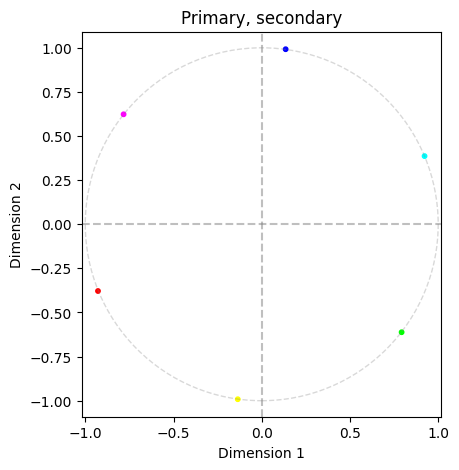

 43%|████▎     | 6000/14000 [00:15<00:18, 429.63it/s, phase=Bright hues only, lr=0.001000, loss=0.0000, recon=0.0000, anchor=0.0000]                           

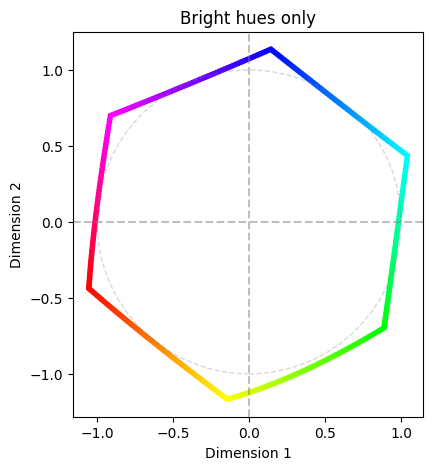

 57%|█████▋    | 8000/14000 [00:20<00:15, 392.93it/s, phase=Slightly darker hues, lr=0.001000, loss=0.0000, recon=0.0000, anchor=0.0000]

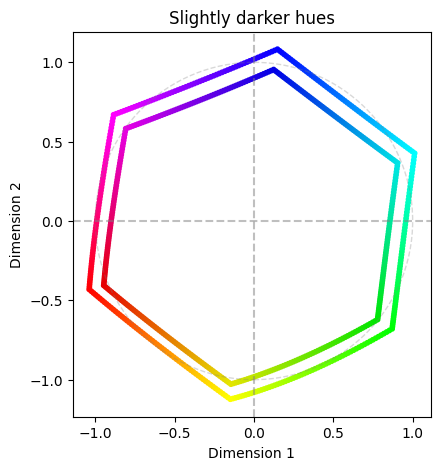

 71%|███████▏  | 10000/14000 [00:25<00:10, 393.55it/s, phase=Brightness levels extended, lr=0.001000, loss=0.0000, recon=0.0000, norm=0.0000, anchor=0.0000]

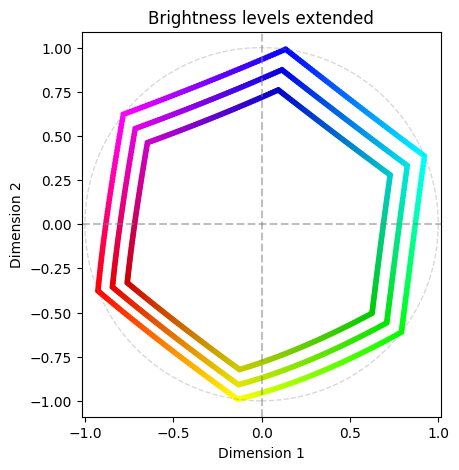

 86%|████████▌ | 12000/14000 [00:31<00:06, 310.34it/s, phase=All brightness levels, lr=0.001000, loss=0.0000, recon=0.0000, norm=0.0000, anchor=0.0000]     

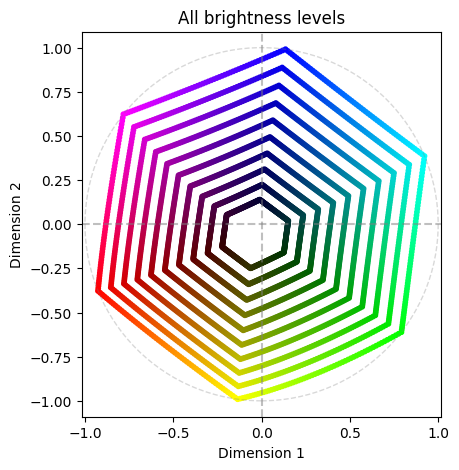

100%|██████████| 14000/14000 [00:37<00:00, 349.84it/s, phase=All brightness levels, lr=0.001000, loss=0.0000, recon=0.0000, norm=0.0000, anchor=0.0000]

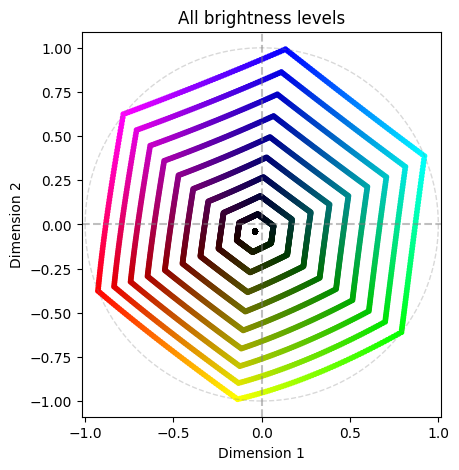

100%|██████████| 14000/14000 [00:37<00:00, 374.27it/s, phase=All brightness levels, lr=0.001000, loss=0.0000, recon=0.0000, norm=0.0000, anchor=0.0000]


In [6]:
from typing import Literal
import numpy as np
import torch.nn as nn
from tqdm import tqdm

from ex_color.data import ColorCube, hue_arange


def loss_reg(fn):
    """Adapt loss function to look like a regularizer"""

    def wrapper(data: Tensor, res: InferenceResult) -> Tensor:
        return fn(data, res.outputs)

    return wrapper


def unit_norm(data: Tensor, res: InferenceResult) -> Tensor:
    """Regularize latents to have unit norm"""
    norms = torch.norm(res.latents, dim=1)
    return torch.mean((norms - 1.0) ** 2)


def planar(data: Tensor, res: InferenceResult) -> Tensor:
    """Regularize latents to be planar in the first two channels"""
    return torch.mean(res.latents[:, 2:] ** 2)


def separate(data: Tensor, res: InferenceResult) -> Tensor:
    """Regularize latents to be separated from each other in first two channels"""
    # Get pairwise differences in the first two dimensions
    points = res.latents[:, :2]  # Shape: [n, 2]
    diffs = points.unsqueeze(1) - points.unsqueeze(0)  # Shape: [n, n, 2]

    # Calculate squared distances
    sq_dists = torch.sum(diffs**2, dim=2)  # Shape: [n, n]

    # Remove self-distances (diagonal)
    mask = 1.0 - torch.eye(sq_dists.shape[0], device=sq_dists.device)
    masked_sq_dists = sq_dists * mask

    # Encourage separation by minimizing inverse distances
    # (creates stronger repulsion between close points)
    epsilon = 1e-6  # Prevent division by zero
    return torch.mean(1.0 / (masked_sq_dists + epsilon))


class AnchorRegularizer(DeltaRegularizer):
    """Regularize latents to be close to their position in the reference phase"""

    def __init__(self, reference: str):
        self.reference = reference

    def __call__(self, data: Tensor, current: InferenceResult, former: InferenceResult) -> Tensor:
        return torch.mean((current.latents - former.latents) ** 2)


def constant_weight_schedule(epochs: int, epoch: int) -> float:
    return 1.0


class CosineWeightSchedule(WeightSchedule):
    """Cosine weight schedule for regularization"""

    def __init__(self, cycles: int, finish: Literal['high', 'low']):
        self.cycles = cycles
        self.finish = finish

    def __call__(self, epochs: int, epoch: int) -> float:
        freq = self.cycles * 2
        if self.finish == 'high':
            freq += 1
        return (1 - np.cos(epoch / epochs * freq * np.pi)) / 2


class RampWeightSchedule(WeightSchedule):
    """Ramp weight schedule for regularization"""

    def __init__(self, end_at: float):
        self.end_at = end_at

    def __call__(self, epochs: int, epoch: int) -> float:
        return epoch / epochs * self.end_at


def train_color_model(model: ColorMLP, curriculum: list[CurriculumPhase], base_lr=0.001, warmup_fraction=0.1):
    from torch import optim
    from torch.optim.lr_scheduler import LinearLR
    from tqdm import tqdm

    # Create optimizer once for the entire training process
    optimizer = optim.Adam(model.parameters(), lr=base_lr)

    phase_history: dict[str, tuple[CurriculumPhase, InferenceResult]] = {}

    total_epochs = sum(phase.epochs for phase in curriculum)

    with tqdm(total=total_epochs) as pbar:
        for phase in curriculum:
            warmup_epochs = max(1, int(phase.epochs * warmup_fraction))
            scheduler = LinearLR(
                optimizer,
                start_factor=1 / warmup_epochs,
                end_factor=1.0,
                total_iters=warmup_epochs,
            )

            # Collect input data
            datasets: dict[str, Tensor] = {}
            for loss_term in phase.loss_terms:
                if isinstance(loss_term.criterion, DeltaRegularizer):
                    ref_phase, _ref_results = phase_history[loss_term.criterion.reference]
                    datasets[loss_term.criterion.reference] = ref_phase.data
                else:
                    datasets[phase.name] = phase.data

            for epoch in range(phase.epochs):
                pbar.update(1)
                optimizer.zero_grad()

                results: dict[str, InferenceResult] = {}
                for name, data in datasets.items():
                    outputs, latents = model(data)
                    results[name] = InferenceResult(outputs, latents)

                # Calculate loss (including regularization terms)
                losses: dict[str, Tensor] = {}
                for loss_term in phase.loss_terms:
                    weight = loss_term.calc_weight(phase.epochs, epoch)
                    if isinstance(loss_term.criterion, DeltaRegularizer):
                        key = loss_term.criterion.reference
                        ref_data = datasets[key]
                        curr_results = results[key]
                        prior_results = phase_history[key][1]
                        losses[loss_term.name] = weight * loss_term.criterion(ref_data, curr_results, prior_results)
                    else:
                        losses[loss_term.name] = weight * loss_term.criterion(datasets[name], results[name])
                loss = sum(losses.values(), start=torch.tensor(0.0))

                # Backward pass
                loss.backward()
                optimizer.step()
                scheduler.step()

                # current_lr = optimizer.param_groups[0]['lr']
                pbar.set_postfix(
                    {
                        'phase': phase.name,
                        'lr': f'{scheduler.get_last_lr()[0]:.6f}',
                        'loss': f'{loss.item():.4f}',
                        **{name: f'{lt.item():.4f}' for name, lt in losses.items()},
                    },
                )

            with torch.no_grad():
                outputs, latents = model(phase.data)
                phase_history[phase.name] = (phase, InferenceResult(outputs.clone(), latents.clone()))
                _fig = plot_latent_space(latents, phase.data, title=phase.name)
                plt.show()

    return phase_history


curriculum = [
    CurriculumPhase(
        name='Primary, secondary',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=1 / 6),
                s=np.array([1]),
                v=np.array([1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=4000,
        loss_terms=[
            LossTerm('recon', 1.0, constant_weight_schedule, loss_reg(nn.MSELoss())),
            LossTerm('sep', 0.1, CosineWeightSchedule(2, 'low'), separate),
            LossTerm('norm', 0.3, CosineWeightSchedule(4, 'high'), unit_norm),
            LossTerm('planar', 0.1, CosineWeightSchedule(4, 'high'), planar),
        ],
    ),
    CurriculumPhase(
        name='Bright hues only',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=1 / 360),
                s=np.array([1]),
                v=np.array([1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=2000,
        loss_terms=[
            LossTerm('recon', 1.0, constant_weight_schedule, loss_reg(nn.MSELoss())),
            LossTerm('anchor', 0.001, CosineWeightSchedule(3, 'high'), AnchorRegularizer('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='Slightly darker hues',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=1 / 360),
                s=np.array([1]),
                v=np.linspace(0.9, 1, 2),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=2000,
        loss_terms=[
            LossTerm('recon', 1.0, constant_weight_schedule, loss_reg(nn.MSELoss())),
            LossTerm('anchor', 0.001, CosineWeightSchedule(3, 'high'), AnchorRegularizer('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='Brightness levels extended',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=1 / 360),
                s=np.array([1]),
                v=np.linspace(0.8, 1, 3),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=2000,
        loss_terms=[
            LossTerm('recon', 1.0, constant_weight_schedule, loss_reg(nn.MSELoss())),
            LossTerm('norm', 0.1, CosineWeightSchedule(3, 'high'), unit_norm),
            LossTerm('anchor', 0.02, CosineWeightSchedule(3, 'high'), AnchorRegularizer('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='All brightness levels',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=1 / 360),
                s=np.array([1]),
                v=np.linspace(0.2, 1, 10),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=2000,
        loss_terms=[
            LossTerm('recon', 1.0, constant_weight_schedule, loss_reg(nn.MSELoss())),
            LossTerm('norm', 0.1, CosineWeightSchedule(3, 'high'), unit_norm),
            LossTerm('anchor', 0.1, CosineWeightSchedule(3, 'high'), AnchorRegularizer('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='All brightness levels',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=1 / 360),
                s=np.array([1]),
                v=np.linspace(0, 1, 10),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=2000,
        loss_terms=[
            LossTerm('recon', 1.0, constant_weight_schedule, loss_reg(nn.MSELoss())),
            LossTerm('norm', 0.1, CosineWeightSchedule(3, 'high'), unit_norm),
            LossTerm('anchor', 0.1, CosineWeightSchedule(3, 'high'), AnchorRegularizer('Primary, secondary')),
        ],
    ),
]

model = ColorMLP(normalize_bottleneck=False)

history = train_color_model(
    model,
    curriculum,
    base_lr=0.001,
    warmup_fraction=0.1,
)